# Use Python function to recognize hand-written digits with `ibm-watson-machine-learning`

Create and deploy a function that receives HTML canvas image data from a web app and then processes and sends that data to a model trained to recognize handwritten digits.  
See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deployed-func-mnist-tutorial.html" target="_blank">MNIST function deployment tutorial</a>  

This notebook runs on Python.

## Learning goals

The learning goals of this notebook are:

-  AI function definition
-  Store AI function
-  Deployment creation

## Contents

This notebook contains the following parts:
1. [Setup](#setup)
2. [Get an ID for a model deployment](#step4)
3. [Get sample canvas data](#step5)
4. [Create a deployable function](#step6)
5. [Store and deploy the function](#step7)
6. [Test the deployed function](#step8)
7. [Clean up](#cleanup)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'oSxBBknDwEvXPyqmb8rNmoZ2vX1ue8CqeqmlJUV2me93'
location = 'us-south'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
!pip install -U ibm-watson-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.7 MB/s eta 0:00:0031m10.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.5 MB/s eta 0:00:00MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.4/967.4 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.12.2-py3-none-any.whl size=73914 sha256=1790ce0b3fb7369fa1aa54bbfd24e904e573f03ca6760f8a3c2de7165baad653
  Stored in directory: /Users/harry/Library/Caches/pip/wheels/9b/69/0e/bbb119cf7763dba4ecf6ad2fa19268794e1cbe51f46fc48377
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.12.2-py3-none-any.whl size=564554 sha256=a7dbafb5fcd366feda4665337d982e1f4d944b9fcd

In [4]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

You can use `list` method to print all existing spaces.

In [5]:
space_id = 'a7058dca-e24f-43b8-a7df-f331b615586e'

In [6]:
client.spaces.list(limit=10)

------------------------------------  ----------  ------------------------
ID                                    NAME        CREATED
a7058dca-e24f-43b8-a7df-f331b615586e  mnistspace  2023-02-25T19:26:36.856Z
------------------------------------  ----------  ------------------------


To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [7]:
client.set.default_space(space_id)

'SUCCESS'

## 2. <a id="step4"></a> Get an ID for a model deployment

The deployed function created in this notebook is designed to send payload data to a TensorFlow model created in the <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-mnist-tutorials.html" target="_blank" rel="noopener noreferrer">MNIST tutorials</a>.

In [8]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2f902dcecc988f78a44902bb38c7c125d7f114fc16d7593461aec121eeb50638
  Stored in directory: /Users/harry/Library/Caches/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [9]:
import os, wget, json
import numpy as np
import matplotlib.pyplot as plt
import requests

### Option 1: Use your own, existing model deployment

If you already deployed a model while working through one of the following MNIST tutorials, you can use that model deployment:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder.html" target="_blank" rel="noopener noreferrer">Experiment builder MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_experiment-builder_hpo.html" target="_blank" rel="noopener noreferrer">Experiment builder (HPO) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python client (notebook) MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_tutorial_tensorflow_cli.html" target="_blank" rel="noopener noreferrer">CLI MNIST tutorial</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_cli_with_hpo.html" target="_blank" rel="noopener noreferrer">CLI (HPO) MNIST tutorial</a>

Paste the model deployment ID in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-endpoint-url.html" target="_blank" rel="noopener noreferrer">Looking up an online deployment ID</a>


In [10]:
model_deployment_id = ""

### Option 2: Download, store, and deploy a sample model
You can deployed a sample model and get its deployment ID by running the code in the following four cells.

In [11]:
# Download a sample model to the notebook working directory

sample_saved_model_filename = 'mnist-tf-hpo-saved-model.tar.gz'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/tensorflow/mnist/' + sample_saved_model_filename
if not os.path.isfile(sample_saved_model_filename): wget.download(url)

 15% [...........                                                             ]  5447680 / 34803755

 45% [................................                                        ] 15728640 / 34803755

 80% [..........................................................              ] 28164096 / 34803755

100% [........................................................................] 34803755 / 34803755

In [12]:
# Look up software specification for the MNIST model

sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")

In [13]:
# Store the sample model in your Watson Machine Learning repository

metadata = {
            client.repository.ModelMetaNames.NAME: 'Saved MNIST model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.7',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}
model_details = client.repository.store_model(
    model=sample_saved_model_filename,
    meta_props=metadata
)

In [14]:
# Get published model ID

published_model_uid = client.repository.get_model_uid(model_details)

This method is deprecated, please use get_model_id()


/opt/homebrew/lib/python3.10/site-packages/ibm_watson_machine_learning/repository.py:605: UserWarning: This method is deprecated, please use get_model_id()
  warn("This method is deprecated, please use get_model_id()")


In [15]:
# Deploy the stored model
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST saved model deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

model_deployment_details = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'cb88dbf3-9c17-4a4e-b4eb-250b0993debc' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='eb890746-1459-41c7-be60-23d45d145d9b'
------------------------------------------------------------------------------------------------




In [16]:
# Get the ID of the model deployment just created

model_deployment_id = client.deployments.get_uid(model_deployment_details)
print(model_deployment_id)

eb890746-1459-41c7-be60-23d45d145d9b


## <a id="step5"></a> 3. Get sample canvas data

The deployed function created in this notebook is designed to accept RGBA image data from an HTML canvas object in one of these sample apps:

- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Node.js MNIST sample app</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Python Flask MNIST sample app</a>

Run the following cells to download and view sample canvas data for testing the deployed function.

### 3.1 Download sample data file

In [17]:
# Download the file containing the sample data

sample_canvas_data_filename = 'mnist-html-canvas-image-data.json'
url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/data/mnist/' + sample_canvas_data_filename
if not os.path.isfile(sample_canvas_data_filename): wget.download(url)

100% [............................................................................] 475816 / 475816

In [18]:
# Load the sample data from the file into a variable

with open(sample_canvas_data_filename) as data_file:
    sample_cavas_data = json.load(data_file)

### 3.2 View sample data

In [19]:
# View the raw contents of the sample data

print("Height (n): " + str(sample_cavas_data["height"]) + " pixels\n")
print("Num image data entries: " + str(len( sample_cavas_data["data"])) + " - (n * n * 4) elements - RGBA values\n")
print(json.dumps(sample_cavas_data, indent=3)[:75] + "...\n" + json.dumps(sample_cavas_data, indent=3)[-50:])

Height (n): 187 pixels

Num image data entries: 139876 - (n * n * 4) elements - RGBA values

{
   "data": [
      0,
      0,
      0,
      0,
      0,
      0,
      ...
      0,
      0,
      0
   ],
   "height": 187
}


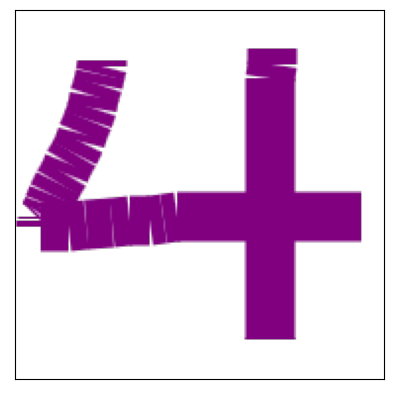

In [20]:
# See what hand-drawn digit the sample data represents

rgba_arr = np.asarray(sample_cavas_data["data"]).astype('uint8')
n = sample_cavas_data["height"]
plt.figure()
plt.imshow( rgba_arr.reshape(n, n, 4))
plt.xticks([])
plt.yticks([])
plt.show()

## <a id="step6"></a> 4. Create a deployable function

The basics of creating and deploying functions in Watson Machine Learning are given here:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-deploy-functions.html" target="_blank" rel="noopener noreferrer">Creating and deploying functions</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-functions.html" target="_blank" rel="noopener noreferrer">Implementation details of deployable functions</a>


### 4.1 Define the function
1. Define a Python closure with an inner function named "score".
2. Use default parameters to save your Watson Machine Learning credentials and the model deployment ID with the deployed function.
3. Process the canvas data (reshape and normalize) and then send the processed data to the model deployment.
4. Process the results from the model deployment so the deployed function returns simpler results.
5. Implement error handling so the function will behave gracefully if there is an error.

In [21]:
ai_parms = {"wml_credentials": wml_credentials, "space_id": space_id, "model_deployment_id": model_deployment_id}

def my_deployable_function( parms=ai_parms ):
    
    try:
        
        import subprocess
        subprocess.check_output("pip install pillow --user", stderr=subprocess.STDOUT, shell=True)
        
    except subprocess.CalledProcessError as e:        
        install_err = "subprocess.CalledProcessError:\n\n" + "cmd:\n" + e.cmd + "\n\noutput:\n" + e.output.decode()
        raise Exception("Installing failed:\n" + install_err)
    
        
    def getRGBAArr(canvas_data):
        import numpy as np
        dimension = canvas_data["height"]
        rgba_data = canvas_data["data"]
        rgba_arr  = np.asarray(rgba_data).astype('uint8')
        return rgba_arr.reshape(dimension, dimension, 4)
        
    def getNormAlphaList(img):
        import numpy as np
        alpha_arr       = np.array(img.split()[-1])
        norm_alpha_arr  = alpha_arr / 255
        norm_alpha_list = norm_alpha_arr.reshape(1, 784).tolist()
        return norm_alpha_list
        
    def score(function_payload):
            
        try:
            
            from PIL import Image
            canvas_data   = function_payload["input_data"][0]["values"][0]           # Read the payload received by the function
            rgba_arr      = getRGBAArr(canvas_data)               # Create an array object with the required shape
            img           = Image.fromarray(rgba_arr, 'RGBA')     # Create an image object that can be resized
            sm_img        = img.resize((28, 28), Image.LANCZOS) # Resize the image to 28 x 28 pixels
            alpha_list    = getNormAlphaList(sm_img)              # Create a 1 x 784 array of values between 0 and 1
            model_payload = {"input_data": [{"values" : alpha_list}]}               # Create a payload to be sent to the model
                    
            #print( "Payload for model:" ) # For debugging purposes
            #print( model_payload )        # For debugging purposes
                    
            from ibm_watson_machine_learning import APIClient
            client       = APIClient(parms["wml_credentials"])
            client.set.default_space(parms["space_id"])
            model_result = client.deployments.score(parms["model_deployment_id"], model_payload)
            digit_class  = model_result["predictions"][0]["values"][0]
                    
            return model_result
        
        except Exception as e:
            
            return {'predictions': [{'values': [repr(e)]}]}
            #return {"error" : repr(e)}


    return score

### 4.2 Test locally
You can test your function in the notebook before deploying the function.

To see debugging info:
1. Uncomment the print statements inside the score function
2. Rerun the cell defining the function
3. When you rerun the this cell, you will see the debugging info

In [22]:
# Pass the sample canvas data to the function as a test

func_result = my_deployable_function()({"input_data": [{"values": [sample_cavas_data]}]})
print(func_result)

/var/folders/v5/x5knzrz54qz3b71pj46kk_9m0000gn/T/ipykernel_64868/225202758.py:37: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  sm_img        = img.resize((28, 28), Image.LANCZOS) # Resize the image to 28 x 28 pixels


{'predictions': [{'id': 'classes', 'values': [4]}]}


## <a id="step7"></a> 5. Store and deploy the function
Before you can deploy the function, you must store the function in your Watson Machine Learning repository.

In [23]:
# Look up software specification for the deployable function

sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-22.1-py3.9")

In [24]:
# Store the deployable function in your Watson Machine Learning repository

meta_data = {
    client.repository.FunctionMetaNames.NAME: 'MNIST deployable function',
    client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

function_details = client.repository.store_function(meta_props=meta_data, function=my_deployable_function)

In [25]:
# Get published function ID

function_uid = client.repository.get_function_uid(function_details)

In [26]:
# Deploy the stored function

metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "MNIST function deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

function_deployment_details = client.deployments.create(function_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'c0f90d5f-7afe-4766-9bf8-a2e74fdd35d3' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='1919f494-428c-427c-845c-2dfa1463515d'
------------------------------------------------------------------------------------------------




## <a id="step8"></a> 6. Test the deployed function

You can use the Watson Machine Learning Python client or REST API to send data to your function deployment for processing in exactly the same way you send data to model deployments for processing.

In [27]:
# Get the endpoint URL of the function deployment just created

function_deployment_id = client.deployments.get_uid(function_deployment_details)
function_deployment_endpoint_url = client.deployments.get_scoring_href(function_deployment_details)
print(function_deployment_id)
print(function_deployment_endpoint_url)

1919f494-428c-427c-845c-2dfa1463515d
https://us-south.ml.cloud.ibm.com/ml/v4/deployments/1919f494-428c-427c-845c-2dfa1463515d/predictions


In [28]:
payload = {"input_data": [{"values": [sample_cavas_data]}]}

### 6.1 Watson Machine Learning Python client

In [29]:
result = client.deployments.score(function_deployment_id, payload)
if "error" in result:
    print(result["error"])
else:
    print(result)

{'predictions': [{'id': 'classes', 'values': [4]}]}


### 6.2 Watson Machine Learning REST API example

In [30]:
# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = {"Content-Type": "application/x-www-form-urlencoded"}
data    = "apikey=" + wml_credentials["apikey"] + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_iam_uid = "bx"
IBM_cloud_iam_pwd = "bx"
response  = requests.post(url, headers=headers, data=data, auth=(IBM_cloud_iam_uid, IBM_cloud_iam_pwd))

if 200 != response.status_code:
    print(response.status_code)
    print(response.reason)
else:
    iam_token = response.json()["access_token"]
    
    # Send data to deployment for processing
    headers = {"Content-Type"   : "application/json",
               "Authorization"  : "Bearer " + iam_token}
    params = {"version": "2020-08-01"}
    response = requests.post(function_deployment_endpoint_url, json=payload, params=params, headers=headers)
    print(response.text)

{"predictions": [{"id": "classes", "values": [4]}]}



## <a id="cleanup"></a> 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

## Summary and next steps
In this notebook, you created a Python function that receives HTML canvas image data and then processes and sends that data to a model trained to recognize handwritten digits.

To learn how you can use this deployed function in a web app, see:
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-nodejs-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Node.js app that recognizes hand-drawn digits</a>
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-python-flask-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">Sample Python Flask app that recognizes hand-drawn digits</a>

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.


<hr>
Copyright &copy; IBM Corp. 2018-2020. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>